In [2]:
!pip install sentence-transformers

     |████████████████████████████████| 81kB 7.0MB/s 
     |████████████████████████████████| 2.3MB 29.1MB/s 
     |████████████████████████████████| 1.2MB 49.5MB/s 
     |████████████████████████████████| 901kB 41.7MB/s 
     |████████████████████████████████| 3.3MB 39.0MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.2.0-cp37-none-any.whl size=123339 sha256=32ec1c276ba946ae278a2d68608bd1ecf729cc05cc5f5311621df6c3b690c103
  Stored in directory: /root/.cache/pip/wheels/0f/06/f7/faaa96fdda87462b4fd5c47b343340e9d5531ef70d0eef8242
Successfully built sentence-transformers


In [3]:
import torch
import torch.nn as nn
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer, InputExample, losses, util, evaluation
from os import path
import hashlib
from collections import namedtuple
import shutil
from google.colab import files

device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("whitegrid")



cuda


In [4]:
g_path = './data/'

if path.exists(g_path):
  shutil.rmtree(g_path)


!mkdir data
!wget -P ./data https://raw.githubusercontent.com/cgburgess/sbert-university-names-pytorch/master/data/guesses-labeled.csv 
!wget -P ./data https://raw.githubusercontent.com/cgburgess/sbert-university-names-pytorch/master/data/universities.csv 
!wget -P ./data https://raw.githubusercontent.com/cgburgess/sbert-university-names-pytorch/master/data/world-institutions.csv
!wget -P ./data https://raw.githubusercontent.com/cgburgess/sbert-university-names-pytorch/master/data/world-universities.csv

--2021-06-09 15:58:58--  https://raw.githubusercontent.com/cgburgess/sbert-university-names-pytorch/master/data/guesses-labeled.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6914253 (6.6M) [text/plain]
Saving to: ‘./data/guesses-labeled.csv’

guesses-labeled.csv 100%[===================>]   6.59M  43.5MB/s    in 0.2s    

2021-06-09 15:58:58 (43.5 MB/s) - ‘./data/guesses-labeled.csv’ saved [6914253/6914253]

--2021-06-09 15:58:58--  https://raw.githubusercontent.com/cgburgess/sbert-university-names-pytorch/master/data/universities.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connect

In [5]:
def make_hashes(row):
  to_encode = "".join("{}{}{}".format(row['code'], row['name'], row['url']).split())
  hash = hashlib.md5(to_encode.encode('utf-8'))
  return hash.hexdigest()

# the dirty universities from dblp
with open(path.join(g_path, 'universities.csv'), 'r') as f:
  aff = [line.rstrip() for line in f]

# the clean universitities list that we use to generate the IDS
with open(path.join(g_path, 'world-universities.csv'), 'r') as f:
  clean_unis = pd.read_csv(f)
  clean_unis['is_uni'] = True

with open(path.join(g_path, 'world-institutions.csv'), 'r') as f:
  clean_inst = pd.read_csv(f)
  clean_inst['is_uni'] = False

all = pd.concat([clean_unis, clean_inst], ignore_index=True)
all['id'] = all.apply(make_hashes, axis = 1)

with open(path.join(g_path, 'all_clean.csv'), 'w') as f:
  all.to_csv(f, index=False)

#read in labeled guesses for training
with open(path.join(g_path, 'guesses-labeled.csv'), 'r') as f:
  labeled = pd.read_csv(f)
  labeled.dropna(subset=['label'], inplace=True)

In [58]:
# Examples

sentences = [
"Linyi University, Linyi, China",
"TU Braunschweig, Department of Computer Science, Germany",
"Hassan II, University of Casablanca, Medical Informatics Laboratory, Casablanca, Morocco",
"King's College London, Health Service and Population Research Department, UK",
"University of California Berkeley, Department of Computer Science, CA, USA",
"University of California at Berkeley, Berkeley, CA, USA",
"Department of Computer Science, Rutgers University, New Brunswick, NJ, USA",
"Zuyd University of Applied Sciences, The Netherlands",
"University of California, Santa Cruz, Storage Systems Research Center",
"Yanshan University, Department of Biomedicine Engineering",
"King Fahd University of Petroleum & Minerals, Dhahran, Saudi Arabia",
"University of California, Department of EECS, Berkeley, CA, USA",
"University of North Carolina at Charlotte, College of Computing and Informatics, NC, USA",
"North Carolina State University, Department of Mechanical Engineering, Raleigh, NC, USA",
"Department of Statistics, North Carolina State University",
"University of North Carolina at Wilmington, USA",
"University of California, Department of EECS, Berkeley, CA, USA"]


In [59]:

# uncomment this to use a local saved version of the OG model
# model = SentenceTransformer(path.join(g_path, 'LaBSE_0.model'))

# uncomment this to use the pre-trainined model
# model = SentenceTransformer(path.join(g_path, 'LaBSE_8.model'))

# uncomment this to grab the latest model from the repo (before training on universities)
model = SentenceTransformer('LaBSE')

print(model.max_seq_length)
model.max_seq_length = 128
print(model.max_seq_length)
# model.to(device)
print()


256
128



In [60]:
sentence_embeddings = model.encode(sentences, convert_to_numpy=True)

print(sentence_embeddings.shape)


(17, 768)


In [61]:
distances = cosine_distances(sentence_embeddings)

len(distances[0])

17

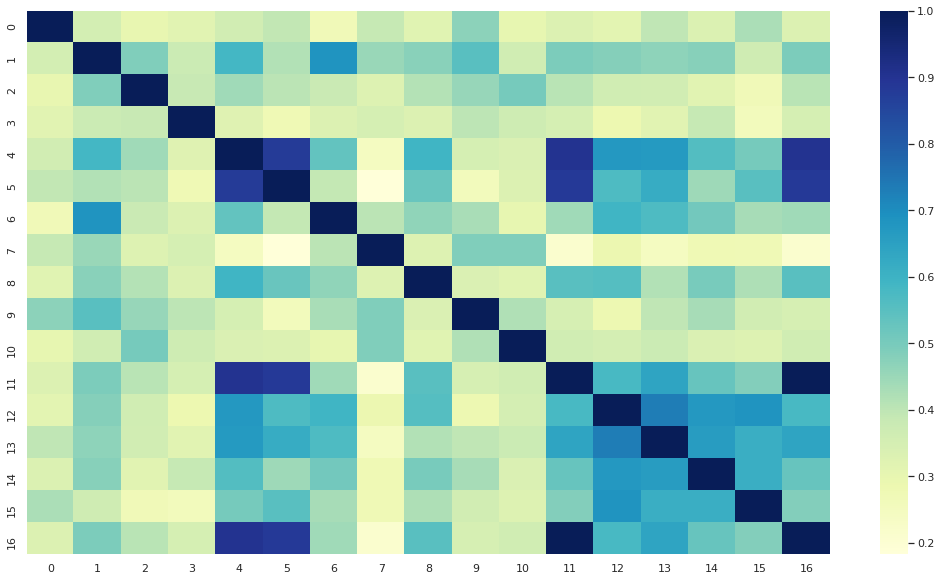

In [62]:
heatmap = sns.heatmap(1-distances, cmap="YlGnBu")


In [32]:
truth_names = all['name'].to_list()

In [33]:
Mapping = namedtuple("Mapping", "index_truth index_unknown probability")

def make_guesses(truth_names, unknown_names, show_progress_bar=False, batch_size=500):
  unknown_embeddings = model.encode(unknown_names, batch_size=batch_size, show_progress_bar=show_progress_bar)
  truth_embeddings = model.encode(truth_names, batch_size=batch_size, show_progress_bar=show_progress_bar)
  sim = cosine_similarity(unknown_embeddings, truth_embeddings)
  idx = np.argmax(sim, axis=1)
  mapped_names = [Mapping(it, iu, np.amax(s)) for it, iu, s in zip(idx, range(len(sim)), sim)]
  return mapped_names


print(make_guesses(["all", "some"], ["a little", "whole", "all"]))


[Mapping(index_truth=1, index_unknown=0, probability=0.8270371), Mapping(index_truth=0, index_unknown=1, probability=0.8390132), Mapping(index_truth=0, index_unknown=2, probability=1.0000002)]


In [34]:
class CollegeLabeled(Dataset):
  def __init__(self, unknowns, mapped, labels):
    self.unknowns = unknowns
    self.mapped = mapped
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    return InputExample(texts=[self.unknowns[index], self.mapped[index]], label=self.labels[index])

dataset = CollegeLabeled(labeled['aff'].to_list(), labeled['mapped_name'].to_list(), labeled['label'].to_list())

test_train_ratio = .847

num_test = int(len(dataset) * test_train_ratio)
train, test = random_split(dataset, [num_test, len(dataset) - num_test])

print("test, train", len(test), len(train))

def map_probs(dataset):
  pairs = [[pair.texts[0], pair.texts[1]] for pair in dataset]
  flattened = [item for pair in pairs for item in pair]
  embeddings = model.encode(flattened, batch_size=128)
  sim = cosine_similarity(embeddings)
  return [(sim[i, i+1],  dataset[i // 2].label) for i in range(0, embeddings.shape[0], 2)]



test, train 91 500


In [35]:
test_probas = []
train_probas = []

In [36]:

#Define your train dataset, the dataloader and the train loss
train_dataloader = DataLoader(train, shuffle=True, batch_size=24)
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test)

train_loss = losses.CosineSimilarityLoss(model)


def callback(score, epoch, steps):
  test_probas.append(map_probs(test))
  train_probas.append(map_probs(train))

#Tune the model
torch.cuda.empty_cache()
model.fit(train_objectives=[(train_dataloader, train_loss)], 
          epochs=8, 
          warmup_steps=100, 
          callback=callback, 
          evaluator=evaluator if len(test) > 0 else None, 
          evaluation_steps=2)

88
88


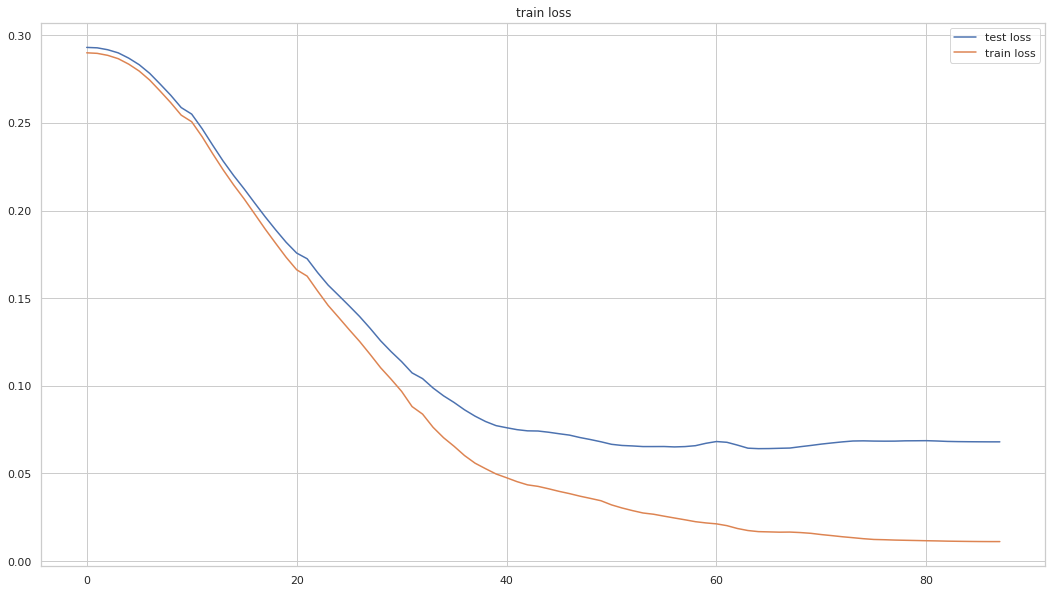

In [37]:
print(len(test_probas))
print(len(train_probas))
test_loss = []
train_loss = []

loss = torch.nn.MSELoss(reduction='mean')

def plot_loss(probas, title):
  # d = pd.DataFrame(probas)
  d = {
      'correct': [],
       'incorrect': []
  }
  for datum in probas:
    correct = []
    inc = []
    for d2 in datum:
      correct.append(d2[0]) if d2[1] == 1.0 else inc.append(d2[0])
    d['correct'].append(np.array(correct))
    d['incorrect'].append(np.array(inc))

  d['correct'] = np.array(d['correct'])
  d['incorrect'] = np.array(d['incorrect'])
  
  mse_correct = np.square(1 - d['correct']).mean(axis=1)
  mse_incorrect = np.square(d['incorrect']).mean(axis=1)

  loss = (mse_correct + mse_incorrect) / 2

  ax = sns.lineplot(data=loss, label=title)

  ax.set_title(title)



plot_loss(test_probas, "test loss")
plot_loss(train_probas, "train loss")

In [38]:
# save_model(model, 8)

In [39]:
# cosine_similarity(model.encode([raw, mapped]))
def plot_model(probas, title):
  # d = pd.DataFrame(probas)
  d = {
      'correct': [],
       'incorrect': []
  }
  for datum in probas:
    correct = []
    inc = []
    for d2 in datum:
      correct.append(d2[0]) if d2[1] == 1.0 else inc.append(d2[0])
    d['correct'].append(correct)
    d['incorrect'].append(inc)
  # print("d",d['incorrect'])
  # data = list(map(lambda x: [a[0] for a in x], probas))
  # data = np.array(data)
  d['correct'] = np.array(d['correct'])
  d['incorrect'] = np.array(d['incorrect'])

  alpha = .6
  ax = sns.lineplot(data=d['incorrect'], palette='Reds', dashes=False, alpha=alpha)
  ax = sns.lineplot(data=d['correct'], palette='Blues', dashes=False, alpha=alpha)
  ax.legend([],[], frameon=False)

  ax.set_title(title)



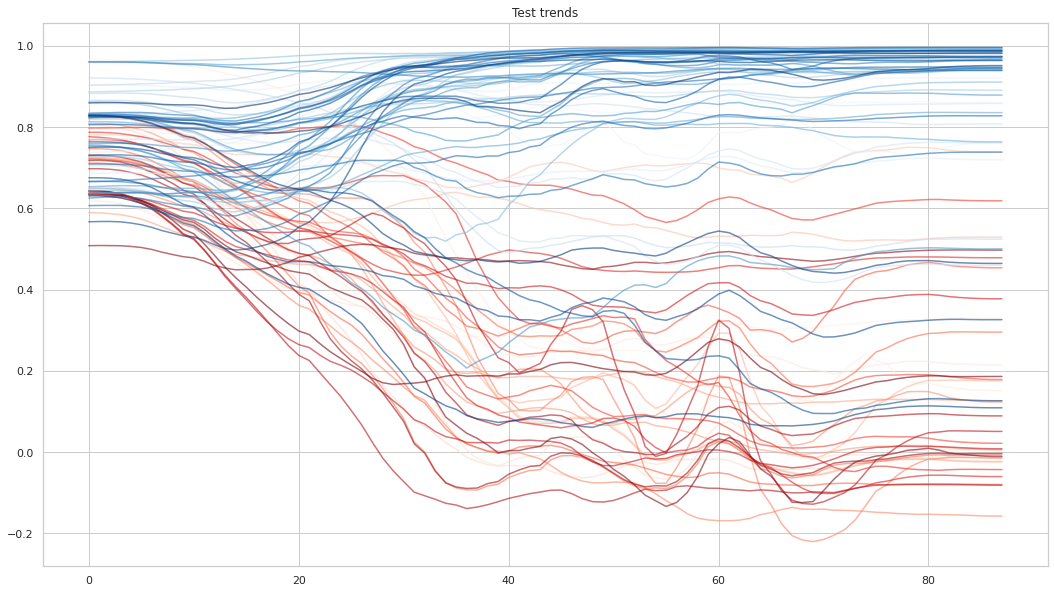

In [40]:
plot_model(test_probas, "Test trends")

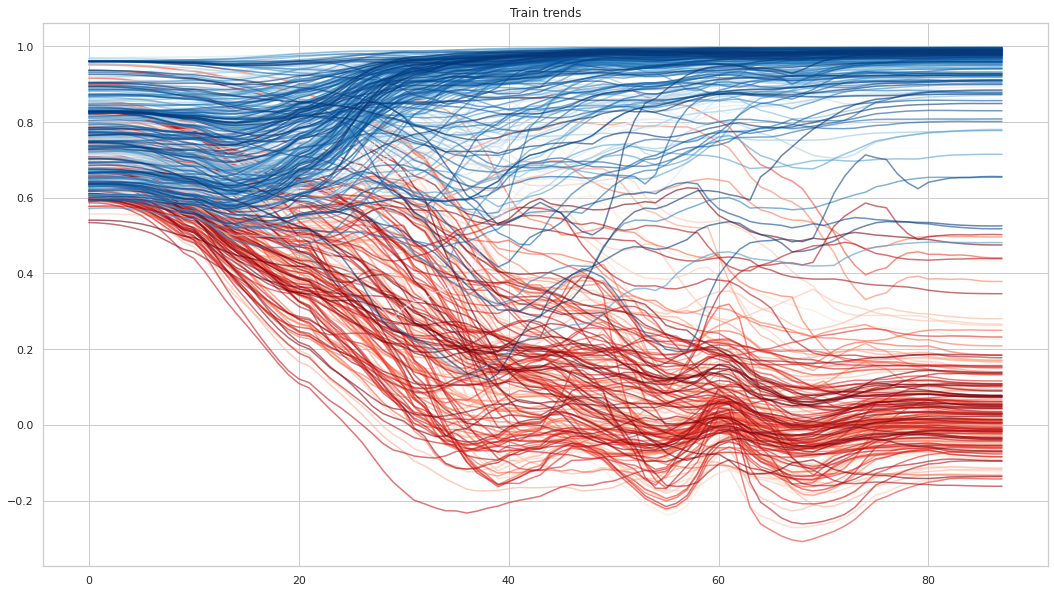

In [41]:
plot_model(train_probas, "Train trends")

In [ ]:
def save_model(model, version=0):
  p = path.join(g_path, 'LaBSE_{}.model'.format(version))
  model.save(p)
  files.download(p)

# save_model(model)


In [54]:
for p in test:
  t = p.texts
  if p.label==0:
    continue
  print(make_guesses([t[0]], [t[1]]))
  print(t)
  print()

[Mapping(index_truth=0, index_unknown=0, probability=0.9945702)]
['University of California, San Diego, Computer Science Department', 'University of California, San Diego']

[Mapping(index_truth=0, index_unknown=0, probability=0.8602644)]
['Jaume I University, Castellon de la Plana, Spain', 'Universitat Jaume I de Castellón']

[Mapping(index_truth=0, index_unknown=0, probability=0.7631866)]
['University of Bremen, BIBA, Germany', 'Universität Bremen']

[Mapping(index_truth=0, index_unknown=0, probability=0.92089057)]
['University of Québec, Montréal, Canada', 'Université du Québec à Montréal']

[Mapping(index_truth=0, index_unknown=0, probability=0.9798036)]
['Brandeis University, Boston, USA', 'Brandeis University']

[Mapping(index_truth=0, index_unknown=0, probability=0.71946824)]
['Federal Unifersity of Uberlandia, Brazil', 'Universidade Federal de Uberlândia']

[Mapping(index_truth=0, index_unknown=0, probability=0.99564123)]
['University of Southern California, Department of Compu